# GUMDPs: Policy optimization in the finite trials regime

Notebook containing the experiments for the illustrative GUMDPs.

In [ ]:
# A valid Gurobi license is needed (https://www.gurobi.com/).
# GUROBI_OPTIONS = {
#    "WLSACCESSID": ,
#    "WLSSECRET": ,
#    "LICENSEID": ,
#}

In [1]:
import os
import math
import json
import itertools
import numpy as np
import matplotlib
import cvxpy as cp
from itertools import product
import matplotlib.pyplot as plt
from tqdm import tqdm

from envs.envs import get_env
from algos.optimistic_planning import OptimisticPlanning
from envs.envs import get_env

import seaborn as sns
sns.set_style("dark")

matplotlib.rcParams['text.usetex'] =  True
plt.rc('text.latex', preamble=r'\usepackage{pifont} \usepackage{amsfonts}')
matplotlib.rcParams.update({'font.size': 16})

sns.set_palette("colorblind")

#### Auxiliary functions

In [2]:
def compute_d_pi(mdp, policy):
    # Args:
    # mdp - MDP specification.
    # policy - policy specification (np.array).

    nS = len(mdp["states"])
    nA = len(mdp["actions"])

    P_pi = np.zeros((nS, nS))
    
    for a in range(nA):
        P_pi += np.dot(np.diag(policy[:,a]), mdp["P"][a])

    d_S = (1 - mdp["gamma"]) * np.dot(mdp["p_0"], np.linalg.inv(np.eye(nS) - mdp["gamma"] * P_pi))
    d_pi = np.dot(np.diag(d_S), policy)
    
    return d_pi

In [3]:
def sample_trajectory(mdp, policy, traj_length):
    # Args:
    # mdp - MDP specification.
    # policy - policy specification (np.array).
    # traj_length - length of the sampled trajectory.

    states = []
    actions = []

    s = np.random.choice(mdp["states"], p=mdp["p_0"])

    for t in range(traj_length):
        states.append(s)

        a = np.random.choice(mdp["actions"], p=policy[s])
        actions.append(a)

        s =  np.random.choice(mdp["states"], p=mdp["P"][a,s,:])

    return states, actions

In [4]:
def estimate_d_pi_from_trajectory(mdp, trajectory_states, trajectory_actions):
    # Args:
    # mdp - MDP specification.
    # trajectory_states - list with sampled states.
    # trajectory_actions - list with sampled actions.
    
    nS = len(mdp["states"])
    nA = len(mdp["actions"])

    d_hats = []
    d_hat = np.zeros((nS,nA))
    for t in range(len(trajectory_states)):
        s_t = trajectory_states[t]
        a_t = trajectory_actions[t]
        
        d_hat[s_t,a_t] += mdp["gamma"]**t * 1

        d_hats.append(((1 - mdp["gamma"])/(1 - mdp["gamma"]**(t+1))) * d_hat)
        
    return np.array(d_hats)

In [5]:
def estimate_f_d_pi_from_samples(mdp, policy, N, K, max_traj_length, flatten=False):
    # Args:
    # mdp - MDP specification.
    # policy - policy specification (np.array).
    # N - number of times K trajectories are sampled.
    # K - number of trajectories to sample.
    # max_traj_length - the maximum length of each sampled trajectory.

    nS = len(mdp["states"])
    nA = len(mdp["actions"])

    f_estimated_list = []
    for n in range(N):

        # Compute d_hat from K sampled trajectories.
        d_hat = np.zeros((max_traj_length,nS,nA))
        for k in range(K):
            traj_states, traj_actions = sample_trajectory(mdp, policy, traj_length=max_traj_length)
            d_hat += estimate_d_pi_from_trajectory(mdp, traj_states, traj_actions)
        d_hat = d_hat / K

        # Compute f(d_hat), d_hat.shape = [max_traj_length, nS, nA].
        if not flatten:
            f_d_hat = np.array([mdp["f"](x) for x in d_hat])
        else:
            f_d_hat = np.array([mdp["f"](x.flatten()) for x in d_hat])

        f_estimated_list.append(f_d_hat)

    return np.array(f_estimated_list) # [N, max_traj_length]

In [6]:
def mean_ci(samples: np.ndarray, num_resamples: int=25_000):
    # Point estimation.
    point_estimate = np.mean(samples)
    # Confidence interval estimation.
    resampled = np.random.choice(samples,
                                size=(len(samples), num_resamples),
                                replace=True)
    point_estimations = np.mean(resampled, axis=0)
    confidence_interval = [np.percentile(point_estimations, 5),
                           np.percentile(point_estimations, 95)]
    return confidence_interval

In [7]:
def construct_random_policy(nS, nA):
    pol = np.ones((nS, nA))
    return pol / np.sum(pol, axis=1, keepdims=True)
# print(construct_random_policy(nS=5, nA=3))

In [8]:
def compute_random_policy_objective(env, mcts_plan_path, data_folder_path="data/", flatten=True):

    # Load MCTS planner data and MDP.
    with open(data_folder_path + mcts_plan_path + "/exp_data.json", 'r') as f:
        mcts_plan_data = json.load(f)
        mcts_plan_data = json.loads(mcts_plan_data)
    f.close()

    # Extract parameters.
    N = int(mcts_plan_data["config"]["N"])
    max_traj_length = int(mcts_plan_data["config"]["H"])
    K = 1 # Single trial setting (K=1).
    gamma = env["gamma"]
    print("N", N)
    print("Max. traj. length:", max_traj_length)
    print("Gamma:", gamma)

    # Compute random policy finite trials objective value.
    random_policy = construct_random_policy(nS=len(env["states"]), nA=len(env["actions"]))
    random_policy_f_estimated = estimate_f_d_pi_from_samples(env, random_policy, N=N, K=K, max_traj_length=max_traj_length, flatten=flatten)

    return np.array(random_policy_f_estimated) # [N,H]

In [9]:
def load_mcts_data(env, mcts_plan_path, data_folder_path="data/"):

    # Load MCTS planner data and MDP.
    with open(data_folder_path + mcts_plan_path + "/exp_data.json", 'r') as f:
        mcts_plan_data = json.load(f)
        mcts_plan_data = json.loads(mcts_plan_data)
    f.close()

    return np.array(mcts_plan_data["f_vals"]) # [N]

#### Plotting functions

In [10]:
def plot_2(DATA_TO_PLOT, mdp_name):

    plt.figure(figsize=(5.0, 4.0))
    
    # Plot f(\hat{d}) of \pi_random.
    random_policy_f_data = DATA_TO_PLOT["random_policy_f"][:,-1]
    cis = mean_ci(random_policy_f_data)
    errors = np.array([np.mean(random_policy_f_data) - cis[0], cis[1] - np.mean(random_policy_f_data)]).reshape(-1,1)
    plt.errorbar(1, np.mean(random_policy_f_data), yerr=errors, capsize=3, fmt='o')

    print("pi_rand:", np.mean(random_policy_f_data), "low_ci=", np.mean(random_policy_f_data) - cis[0], "up_ci=", cis[1] - np.mean(random_policy_f_data))

    # Plot f(\hat{d}) of \pi_\infty^*.
    infinite_trials_policy_f_data = DATA_TO_PLOT["infinite_trials_f"][:,-1]
    cis = mean_ci(infinite_trials_policy_f_data)
    errors = np.array([np.mean(infinite_trials_policy_f_data) - cis[0], cis[1] - np.mean(infinite_trials_policy_f_data)]).reshape(-1,1)
    plt.errorbar(2, np.mean(infinite_trials_policy_f_data), yerr=errors, capsize=3, fmt='o')

    print("pi_infty:", np.mean(infinite_trials_policy_f_data), "low_ci=", np.mean(infinite_trials_policy_f_data) - cis[0], "up_ci=", cis[1] - np.mean(infinite_trials_policy_f_data))

    # Plot f(\hat{d}) of MCTS policy.
    mcts_data = DATA_TO_PLOT["mcts_planner"]
    cis = mean_ci(mcts_data)
    errors = np.array([round(np.mean(mcts_data) - cis[0],4), round(cis[1] - np.mean(mcts_data),4)]).reshape(-1,1)
    plt.errorbar(3, np.mean(mcts_data), yerr=errors, capsize=3, fmt='o')

    print("pi_mcts:", np.mean(mcts_data), "low_ci=", np.mean(mcts_data) - cis[0], "up_ci=", cis[1] - np.mean(mcts_data))
        
    # ax.set_ylim([-1.5,-0.2])
    plt.xticks([1,2,3], [r"$\pi = $ Random", r"$\pi = \pi_\infty^*$", r"$\pi = \pi^*_{MCTS}$"])
    plt.grid()
    #plt.legend()

    plt.ylabel(r'$F_{1,H}(\pi)$')
    
    os.makedirs("figs/", exist_ok=True)
    plt.savefig(f'figs/{mdp_name}_plot2.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()

In [11]:
def plot_3(DATA_TO_PLOT, mdp_name):

    plt.figure(figsize=(5.0, 4.0))
    # fig.tight_layout()
    
    # Plot f(\hat{d}) of \pi_random.
    random_policy_f_data = DATA_TO_PLOT["random_policy_f"][:,-1]
    plt.violinplot(random_policy_f_data, [1], widths=0.3,
                       showmeans=False, showmedians=True, showextrema=True)
    
    # Plot f(\hat{d}) of \pi_\infty^*.
    infinite_trials_policy_f_data = DATA_TO_PLOT["infinite_trials_f"][:,-1]
    plt.violinplot(infinite_trials_policy_f_data, [2], widths=0.3,
                       showmeans=False, showmedians=True, showextrema=True)

    # Plot f(\hat{d}) of MCTS policy.
    mcts_data = DATA_TO_PLOT["mcts_planner"]
    plt.violinplot(mcts_data, [3], widths=0.3,
                       showmeans=False, showmedians=True, showextrema=True)
    
    #ax.set_ylim([-0.01,1.01])
    # ax.set_title(r"$\gamma = $ " + str(gamma_val))
    #ax.set_xlabel(r'$H$')

    plt.grid()
    #ax.legend()
    plt.xticks([1,2,3], [r"$\pi = $ Random", r"$\pi = \pi_\infty^*$", r"$\pi = \pi^*_{MCTS}$"])

    plt.ylabel(r'$F_{1,H}(\pi)$')
    
    os.makedirs("figs/", exist_ok=True)
    plt.savefig(f'figs/{mdp_name}_plot3.pdf', bbox_inches='tight', pad_inches=0)
    plt.show()

## Entropy maximization

#### The objective function is $f(d) = d^\top \log(d) = - \mathcal{H}(d)$

In [12]:
def solve_cvx_opt_problem_entropy(mdp, cvx_obj_f):
    
    nS = len(mdp["states"])
    nA = len(mdp["actions"])
    gamma = mdp["gamma"]
    P_matrix = mdp["P"]
    p_0 = mdp["p_0"]
    
    x = cp.Variable((nS, nA))
    
    constraints = []
    for s in range(nS):
        lhs = cp.sum(x[s, :])
        rhs = (1 - gamma) * p_0[s] + gamma * sum(
            cp.sum(cp.multiply(P_matrix[a][:, s], x[:, a])) for a in range(nA)
        )
        constraints.append(lhs == rhs)
    constraints.append(x >= 0.0)

    obj = cvx_obj_f(x)
    
    prob = cp.Problem(obj, constraints)
    prob.solve()
    
    # print("status:", prob.status)
    # print("optimal value", prob.value)
    # print("optimal var", x.value)

    opt_policy = x.value / np.sum(x.value, axis=1, keepdims=True)

    return prob.value, opt_policy

In [13]:
def compute_infinite_trials_objective_entropy(env, mcts_plan_path, data_folder_path="data/"):

    # Load MCTS planner data and MDP.
    with open(data_folder_path + mcts_plan_path + "/exp_data.json", 'r') as f:
        mcts_plan_data = json.load(f)
        mcts_plan_data = json.loads(mcts_plan_data)
    f.close()

    # Extract parameters.
    N = int(mcts_plan_data["config"]["N"])
    max_traj_length = int(mcts_plan_data["config"]["H"])
    K = 1 # Single trial setting (K=1).
    gamma = env["gamma"]
    print("N", N)
    print("Max. traj. length:", max_traj_length)
    print("Gamma:", gamma)
    
    # Define objective function.
    cvx_obj_f = lambda x: cp.Minimize(-cp.sum(cp.entr(x))) # (Minus) entropy function.
    x_star, opt_policy_infinite_trials = solve_cvx_opt_problem_entropy(env, cvx_obj_f)
    infinite_trials_f_estimated = estimate_f_d_pi_from_samples(env, opt_policy_infinite_trials, N=N, K=K, max_traj_length=max_traj_length, flatten=True)

    return np.array(infinite_trials_f_estimated) # [N,H]

#### Entropy MDP, deterministic, $\mathcal{M}_{f,1}$.

In [14]:
exp_steps = [10,20,50,100,500,1_000,2_000,3_000,4_000]
mcts_planner_data = ['entropy_mdp_00_mcts_gamma_0.9_2025-04-07-10-37-09', 'entropy_mdp_00_mcts_gamma_0.9_2025-04-07-10-37-11', 'entropy_mdp_00_mcts_gamma_0.9_2025-04-07-10-37-15', 'entropy_mdp_00_mcts_gamma_0.9_2025-04-07-10-37-24', 'entropy_mdp_00_mcts_gamma_0.9_2025-04-07-10-37-45', 'entropy_mdp_00_mcts_gamma_0.9_2025-04-07-10-39-33', 'entropy_mdp_00_mcts_gamma_0.9_2025-04-07-10-43-40', 'entropy_mdp_00_mcts_gamma_0.9_2025-04-07-10-53-05', 'entropy_mdp_00_mcts_gamma_0.9_2025-04-07-11-07-12']

exp_idx_to_plot = -1
mcts_data_path = mcts_planner_data[exp_idx_to_plot]
env = get_env("entropy_mdp_00")

data_to_plot = {}
data_to_plot["infinite_trials_f"] = compute_infinite_trials_objective_entropy(env, mcts_data_path)
data_to_plot["random_policy_f"] = compute_random_policy_objective(env, mcts_data_path)
data_to_plot["mcts_planner"] = load_mcts_data(env, mcts_data_path)
#print(data_to_plot)
print("Random policy:", data_to_plot["random_policy_f"][:,-1])
print("Infinite trials policy:", data_to_plot["infinite_trials_f"][:,-1])
print("MCTS planner:", data_to_plot["mcts_planner"])

N 5
Max. traj. length: 100
Gamma: 0.9
N 5
Max. traj. length: 100
Gamma: 0.9
Random policy: [0.03083456 0.09289877 0.01049614 0.10521507 0.12866616]
Infinite trials policy: [0.06349111 0.1443216  0.03375334 0.03750468 0.06214155]
MCTS planner: [0.00227658 0.00227658 0.00227658 0.00227658 0.00227658]


pi_rand: 0.07362214006510225 low_ci= 0.03542431210336476 up_ci= 0.03358358741196775
pi_infty: 0.06824245831781735 low_ci= 0.02656067104286511 up_ci= 0.032602107813787265
pi_mcts: 0.002276580032916422 low_ci= 0.0 up_ci= 0.0


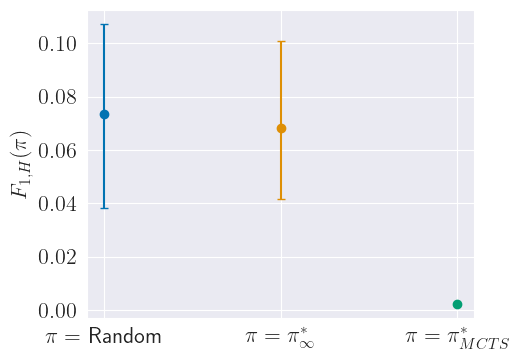

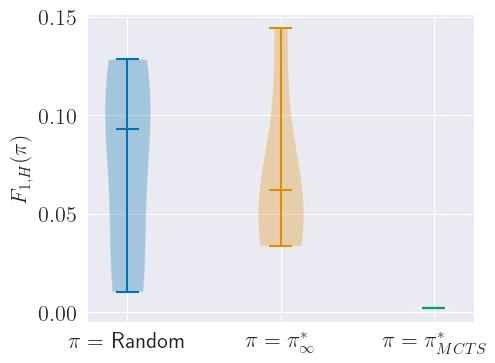

In [15]:
plot_2(data_to_plot, mdp_name=f"entropy_mdp_00_exp_steps_{exp_idx_to_plot}")
plot_3(data_to_plot, mdp_name=f"entropy_mdp_00_exp_steps_{exp_idx_to_plot}")

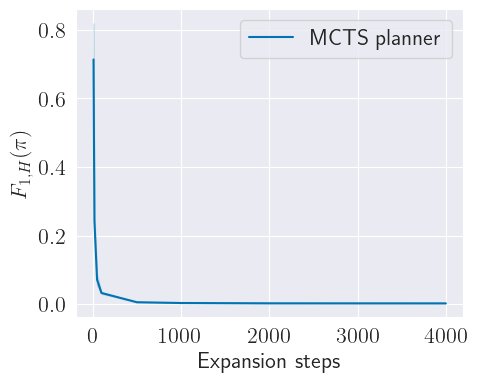

In [16]:
plt.figure(figsize=(5.0, 4.0))

ys_mcts_planner = []
mcts_planner_cis = []

for mcts_data_path in mcts_planner_data:
    y_vals = load_mcts_data(env, mcts_data_path)
    ys_mcts_planner.append(np.mean(y_vals))

    cis = mean_ci(y_vals)
    mcts_planner_cis.append(np.array(cis))

mcts_planner_cis = np.array(mcts_planner_cis)

p = plt.plot(exp_steps, ys_mcts_planner, label="MCTS planner")
plt.fill_between(exp_steps, mcts_planner_cis[:,0], mcts_planner_cis[:,1], color=p[0].get_color(), alpha=0.15)

plt.ylabel(r'$F_{1,H}(\pi)$')
plt.xlabel('Expansion steps')
plt.grid()
plt.legend()

# plt.ylim(-2.0, -1.5)

os.makedirs("figs/", exist_ok=True)
plt.savefig(f'figs/entropy_mdp_00_plot_exp_steps.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

#### Entropy MDP, stochastic, $\mathcal{M}_{f,1}$.

In [17]:
exp_steps = [10,20,50,100,500,1_000,2_000,3_000,4_000]
mcts_planner_data = ['entropy_mdp_10_mcts_gamma_0.9_2025-04-07-14-17-54', 'entropy_mdp_10_mcts_gamma_0.9_2025-04-07-14-17-56', 'entropy_mdp_10_mcts_gamma_0.9_2025-04-07-14-18-01', 'entropy_mdp_10_mcts_gamma_0.9_2025-04-07-14-18-11', 'entropy_mdp_10_mcts_gamma_0.9_2025-04-07-14-18-31', 'entropy_mdp_10_mcts_gamma_0.9_2025-04-07-14-20-19', 'entropy_mdp_10_mcts_gamma_0.9_2025-04-07-14-23-59', 'entropy_mdp_10_mcts_gamma_0.9_2025-04-07-14-31-32', 'entropy_mdp_10_mcts_gamma_0.9_2025-04-07-14-42-59']

exp_idx_to_plot = -1
mcts_data_path = mcts_planner_data[exp_idx_to_plot]

env = get_env("entropy_mdp_10")

data_to_plot = {}
data_to_plot["infinite_trials_f"] = compute_infinite_trials_objective_entropy(env, mcts_data_path)
data_to_plot["random_policy_f"] = compute_random_policy_objective(env, mcts_data_path)
data_to_plot["mcts_planner"] = load_mcts_data(env, mcts_data_path)
#print(data_to_plot)
print("Random policy:", data_to_plot["random_policy_f"][:,-1])
print("Infinite trials policy:", data_to_plot["infinite_trials_f"][:,-1])
print("MCTS planner:", data_to_plot["mcts_planner"])

N 5
Max. traj. length: 100
Gamma: 0.9
N 5
Max. traj. length: 100
Gamma: 0.9
Random policy: [0.124723   0.20120512 0.1089946  0.1261329  0.01821402]
Infinite trials policy: [0.07274321 0.05999763 0.09154772 0.01547045 0.01951807]
MCTS planner: [0.00428475 0.01577057 0.02078083 0.00172496 0.00334446]


pi_rand: 0.11585392812030995 low_ci= 0.0400258793497372 up_ci= 0.03974389951773222
pi_infty: 0.051855417065222356 low_ci= 0.023311367116073813 up_ci= 0.021525474793027424
pi_mcts: 0.009181113700577363 low_ci= 0.005920281497109926 up_ci= 0.006108339202093404


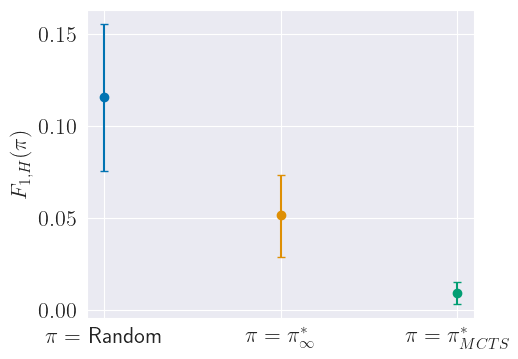

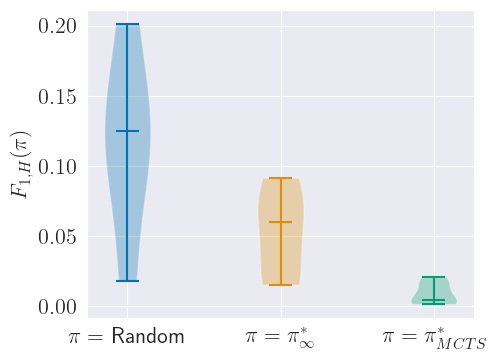

In [18]:
plot_2(data_to_plot, mdp_name=f"entropy_mdp_10_exp_steps_{exp_idx_to_plot}")
plot_3(data_to_plot, mdp_name=f"entropy_mdp_10_exp_steps_{exp_idx_to_plot}")

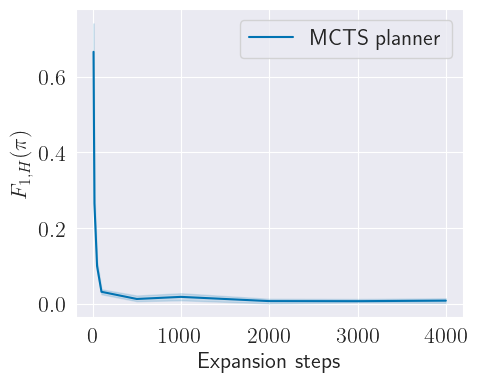

In [19]:
plt.figure(figsize=(5.0, 4.0))

ys_mcts_planner = []
mcts_planner_cis = []

for mcts_data_path in mcts_planner_data:
    y_vals = load_mcts_data(env, mcts_data_path)
    ys_mcts_planner.append(np.mean(y_vals))

    cis = mean_ci(y_vals)
    mcts_planner_cis.append(np.array(cis))

mcts_planner_cis = np.array(mcts_planner_cis)

p = plt.plot(exp_steps, ys_mcts_planner, label="MCTS planner")
plt.fill_between(exp_steps, mcts_planner_cis[:,0], mcts_planner_cis[:,1], color=p[0].get_color(), alpha=0.15)

plt.ylabel(r'$F_{1,H}(\pi)$')
plt.xlabel('Expansion steps')
plt.grid()
plt.legend()

# plt.ylim(-2.0, -1.5)

os.makedirs("figs/", exist_ok=True)
plt.savefig(f'figs/entropy_mdp_10_plot_exp_steps.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## Imitation learning

#### The objective function is $f(d) = \| d - d_\beta\|_2^2, \quad d_\beta \in \Delta(\mathcal{S} \times \mathcal{A})$

In [34]:
import gurobipy as gp
from gurobipy import GRB

def solve_gurobi_opt_problem_imitation_learning(env):

    nS = len(env['states'])
    nA = len(env['actions'])
    gamma = env['gamma']
    P_matrix = env["P"]
    p_0 = env["p_0"]
    d_beta = env["d_beta"]
    print("d_beta", d_beta)

    with gp.Env(params=GUROBI_OPTIONS) as guroby_env, gp.Model(env=guroby_env) as m:
    
        x = m.addVars(nS, nA, lb=0.0, name="x")
    
        for s in range(nS):
            lhs = gp.quicksum(x[s, a] for a in range(nA))
            
            rhs = (1 - gamma) * p_0[s]
            
            for a in range(nA):
                rhs += gamma * gp.quicksum(P_matrix[a][s_prime, s] * x[s_prime, a] for s_prime in range(nS))
            
            m.addConstr(lhs == rhs, name=f"flow_state_{s}")

        quad_expr = gp.QuadExpr()
        for s in range(nS):
            for a in range(nA):
                quad_expr.add(x[s, a] * x[s, a] - 2 * d_beta[s, a] * x[s, a])    
            
        # Set the objective. Change GRB.MAXIMIZE to GRB.MINIMIZE if needed.
        m.setObjective(quad_expr, GRB.MINIMIZE)
        
        m.optimize()

        # Check if the optimization succeeded.
        if m.status != GRB.OPTIMAL:
            raise Exception("Model did not solve optimally.")
    
        # Extract the solution.
        x_opt = np.zeros((nS, nA))
        for s in range(nS):
            for a in range(nA):
                x_opt[s, a] = x[s, a].X

        obj_val = m.ObjVal

    # opt_policy = x_opt / np.sum(x_opt, axis=1, keepdims=True)

    row_sum = np.sum(x_opt, axis=1, keepdims=True)
    opt_policy = np.divide(x_opt, row_sum, out=np.zeros_like(x_opt), where=row_sum != 0)
    
    return obj_val, opt_policy

In [35]:
def compute_infinite_trials_objective_imitation_learning(env, mcts_plan_path, data_folder_path="data/"):

    # Load MCTS planner data and MDP.
    with open(data_folder_path + mcts_plan_path + "/exp_data.json", 'r') as f:
        mcts_plan_data = json.load(f)
        mcts_plan_data = json.loads(mcts_plan_data)
    f.close()

    # Extract parameters.
    N = int(mcts_plan_data["config"]["N"])
    max_traj_length = int(mcts_plan_data["config"]["H"])
    K = 1 # Single trial setting (K=1).
    gamma = env["gamma"]
    print("N", N)
    print("Max. traj. length:", max_traj_length)
    print("Gamma:", gamma)
    
    x_star, opt_policy_infinite_trials = solve_gurobi_opt_problem_imitation_learning(env)
    infinite_trials_f_estimated = estimate_f_d_pi_from_samples(env, opt_policy_infinite_trials, N=N, K=K, max_traj_length=max_traj_length, flatten=False)

    return np.array(infinite_trials_f_estimated) # [N,H]

#### Imitation learning MDP, deterministic, $\mathcal{M}_{f,2}$.

In [ ]:
exp_steps = [10,20,50,100,500,1_000,2_000,3_000,4_000]
mcts_planner_data = ['imitation_learning_mdp_00_mcts_gamma_0.9_2025-04-07-15-07-04', 'imitation_learning_mdp_00_mcts_gamma_0.9_2025-04-07-15-07-06', 'imitation_learning_mdp_00_mcts_gamma_0.9_2025-04-07-15-07-10', 'imitation_learning_mdp_00_mcts_gamma_0.9_2025-04-07-15-07-20', 'imitation_learning_mdp_00_mcts_gamma_0.9_2025-04-07-15-07-41', 'imitation_learning_mdp_00_mcts_gamma_0.9_2025-04-07-15-09-34', 'imitation_learning_mdp_00_mcts_gamma_0.9_2025-04-07-15-13-29', 'imitation_learning_mdp_00_mcts_gamma_0.9_2025-04-07-15-21-43', 'imitation_learning_mdp_00_mcts_gamma_0.9_2025-04-07-15-34-38']

exp_idx_to_plot = -1
mcts_data_path = mcts_planner_data[exp_idx_to_plot]
env = get_env("imitation_learning_mdp_00")

data_to_plot = {}
data_to_plot["infinite_trials_f"] = compute_infinite_trials_objective_imitation_learning(env, mcts_data_path)
data_to_plot["random_policy_f"] = compute_random_policy_objective(env, mcts_data_path, flatten=False)
data_to_plot["mcts_planner"] = load_mcts_data(env, mcts_data_path)
#print(data_to_plot)
print("Random policy:", data_to_plot["random_policy_f"][:,-1])
print("Infinite trials policy:", data_to_plot["infinite_trials_f"][:,-1])
print("MCTS planner:", data_to_plot["mcts_planner"])

pi_rand: 0.07167863809373273 low_ci= 0.02430847031736704 up_ci= 0.014788984162495702
pi_infty: 0.028754711041570114 low_ci= 0.01790992656211849 up_ci= 0.02863699394020155
pi_mcts: 0.00020512457373090634 low_ci= 1.550198176934956e-05 up_ci= 1.6375211804292046e-05


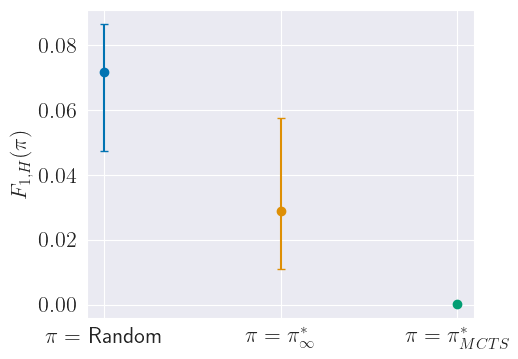

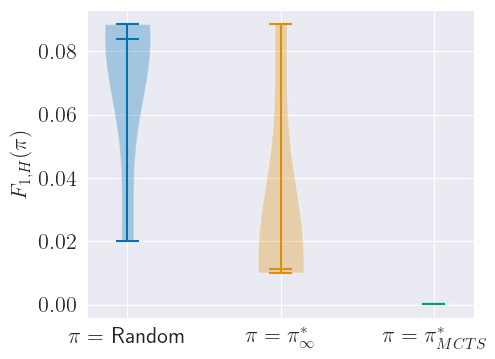

In [39]:
plot_2(data_to_plot, mdp_name=f"imitation_learning_00_mdp_deterministic_exp_steps_{exp_idx_to_plot}")
plot_3(data_to_plot, mdp_name=f"imitation_learning_00_mdp_deterministic_exp_steps_{exp_idx_to_plot}")

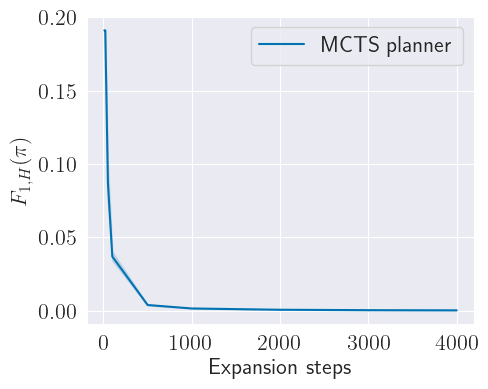

In [40]:
plt.figure(figsize=(5.0, 4.0))

ys_mcts_planner = []
mcts_planner_cis = []

for mcts_data_path in mcts_planner_data:
    y_vals = load_mcts_data(env, mcts_data_path)
    ys_mcts_planner.append(np.mean(y_vals))

    cis = mean_ci(y_vals)
    mcts_planner_cis.append(np.array(cis))

mcts_planner_cis = np.array(mcts_planner_cis)

p = plt.plot(exp_steps, ys_mcts_planner, label="MCTS planner")
plt.fill_between(exp_steps, mcts_planner_cis[:,0], mcts_planner_cis[:,1], color=p[0].get_color(), alpha=0.15)

plt.ylabel(r'$F_{1,H}(\pi)$')
plt.xlabel('Expansion steps')
plt.grid()
plt.legend()

# plt.ylim(-2.0, -1.5)

os.makedirs("figs/", exist_ok=True)
plt.savefig(f'figs/imitation_learning_mdp_00_plot_exp_steps.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

#### Imitation learning MDP, stochastic, $\mathcal{M}_{f,2}$.

In [ ]:
exp_steps = [10,20,50,100,500,1_000,2_000,3_000,4_000]
mcts_planner_data = ['imitation_learning_mdp_10_mcts_gamma_0.9_2025-04-07-16-37-51', 'imitation_learning_mdp_10_mcts_gamma_0.9_2025-04-07-16-37-53', 'imitation_learning_mdp_10_mcts_gamma_0.9_2025-04-07-16-37-57', 'imitation_learning_mdp_10_mcts_gamma_0.9_2025-04-07-16-38-07', 'imitation_learning_mdp_10_mcts_gamma_0.9_2025-04-07-16-38-27', 'imitation_learning_mdp_10_mcts_gamma_0.9_2025-04-07-16-40-13', 'imitation_learning_mdp_10_mcts_gamma_0.9_2025-04-07-16-43-51', 'imitation_learning_mdp_10_mcts_gamma_0.9_2025-04-07-16-51-37', 'imitation_learning_mdp_10_mcts_gamma_0.9_2025-04-07-17-03-34']

exp_idx_to_plot = -1
mcts_data_path = mcts_planner_data[exp_idx_to_plot]
env = get_env("imitation_learning_mdp_10")

data_to_plot = {}
data_to_plot["infinite_trials_f"] = compute_infinite_trials_objective_imitation_learning(env, mcts_data_path)
data_to_plot["random_policy_f"] = compute_random_policy_objective(env, mcts_data_path, flatten=False)
data_to_plot["mcts_planner"] = load_mcts_data(env, mcts_data_path)
#print(data_to_plot)
print("Random policy:", data_to_plot["random_policy_f"][:,-1])
print("Infinite trials policy:", data_to_plot["infinite_trials_f"][:,-1])
print("MCTS planner:", data_to_plot["mcts_planner"])

pi_rand: 0.05206146718965769 low_ci= 0.02399660388020353 up_ci= 0.022523053624049147
pi_infty: 0.027379790800300056 low_ci= 0.009907794056200299 up_ci= 0.011265729989603124
pi_mcts: 0.0015317025359497221 low_ci= 0.0010855917990833307 up_ci= 0.0011380297571640288


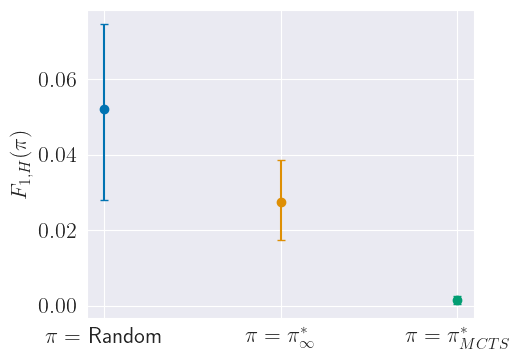

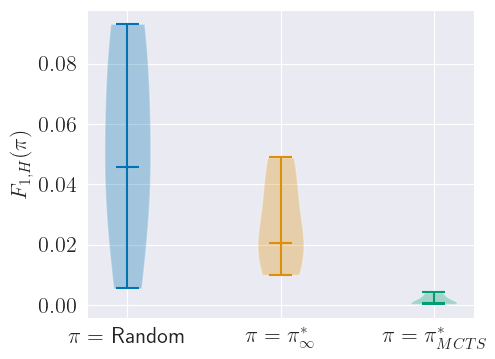

In [44]:
plot_2(data_to_plot, mdp_name=f"imitation_learning_10_mdp_deterministic_exp_steps_{exp_idx_to_plot}")
plot_3(data_to_plot, mdp_name=f"imitation_learning_10_mdp_deterministic_exp_steps_{exp_idx_to_plot}")

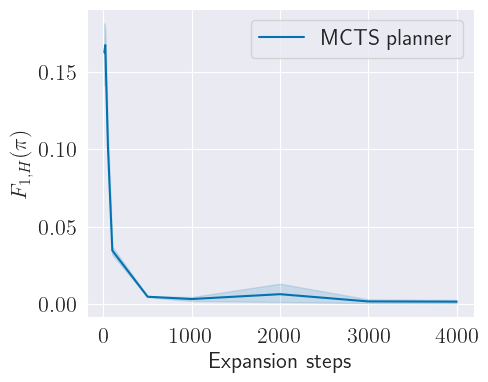

In [45]:
plt.figure(figsize=(5.0, 4.0))

ys_mcts_planner = []
mcts_planner_cis = []

for mcts_data_path in mcts_planner_data:
    y_vals = load_mcts_data(env, mcts_data_path)
    ys_mcts_planner.append(np.mean(y_vals))

    cis = mean_ci(y_vals)
    mcts_planner_cis.append(np.array(cis))

mcts_planner_cis = np.array(mcts_planner_cis)

p = plt.plot(exp_steps, ys_mcts_planner, label="MCTS planner")
plt.fill_between(exp_steps, mcts_planner_cis[:,0], mcts_planner_cis[:,1], color=p[0].get_color(), alpha=0.15)

plt.ylabel(r'$F_{1,H}(\pi)$')
plt.xlabel('Expansion steps')
plt.grid()
plt.legend()

# plt.ylim(-2.0, -1.5)

os.makedirs("figs/", exist_ok=True)
plt.savefig(f'figs/imitation_learning_mdp_10_plot_exp_steps.pdf', bbox_inches='tight', pad_inches=0)
plt.show()

## Adversarial MDP

In [19]:
import gurobipy as gp
from gurobipy import GRB

def solve_gurobi_opt_problem_adversarial_mdp(env):

    nS = len(env['states'])
    nA = len(env['actions'])
    gamma = env['gamma']
    P_matrix = env["P"]
    p_0 = env["p_0"]
    cost_f_1 = np.array(env["cost_f1"])
    cost_f_2 = np.array(env["cost_f2"])
    cost_f_3 = np.array(env["cost_f3"])
    print("cost_f_1", cost_f_1)

    with gp.Env(params=GUROBI_OPTIONS) as guroby_env, gp.Model(env=guroby_env) as m:
    
        x = m.addVars(nS, nA, lb=0.0, name="x")
    
        for s in range(nS):
            lhs = gp.quicksum(x[s, a] for a in range(nA))
            
            rhs = (1 - gamma) * p_0[s]
            
            for a in range(nA):
                rhs += gamma * gp.quicksum(P_matrix[a][s_prime, s] * x[s_prime, a] for s_prime in range(nS))
            
            m.addConstr(lhs == rhs, name=f"flow_state_{s}")

        # Auxiliary variable
        t = m.addVar(name="t")
        
        # Build expressions
        expr1 = gp.quicksum(cost_f_1[s, a] * x[s, a] for s in range(nS) for a in range(nA))
        expr2 = gp.quicksum(cost_f_2[s, a] * x[s, a] for s in range(nS) for a in range(nA))
        expr3 = gp.quicksum(cost_f_3[s, a] * x[s, a] for s in range(nS) for a in range(nA))

        # Instead of addGenConstrMax, add two constraints manually
        m.addConstr(t >= expr1, name="max_constraint_expr1")
        m.addConstr(t >= expr2, name="max_constraint_expr2")
        m.addConstr(t >= expr3, name="max_constraint_expr3")
        
        # Set objective
        m.setObjective(t, GRB.MINIMIZE)
        
        m.optimize()

        # Check if the optimization succeeded.
        if m.status != GRB.OPTIMAL:
            raise Exception("Model did not solve optimally.")
    
        # Extract the solution.
        x_opt = np.zeros((nS, nA))
        for s in range(nS):
            for a in range(nA):
                x_opt[s, a] = x[s, a].X

        obj_val = m.ObjVal

    opt_policy = x_opt / np.sum(x_opt, axis=1, keepdims=True)

    # row_sum = np.sum(x_opt, axis=1, keepdims=True)
    # opt_policy = np.divide(x_opt, row_sum, out=np.zeros_like(x_opt), where=row_sum != 0)
    
    return obj_val, opt_policy

In [20]:
def load_and_compute_data_adversarial_mdp(mcts_plan_path, data_folder_path="data/"):
    
    # Load MCTS planner data and MDP.
    with open(data_folder_path + mcts_plan_path + "/exp_data.json", 'r') as f:
        mcts_plan_data = json.load(f)
        mcts_plan_data = json.loads(mcts_plan_data)
    f.close()
    
    # Extract parameters.
    N = int(mcts_plan_data["config"]["N"])
    print("N:", N)
    max_traj_length = int(mcts_plan_data["config"]["H"])
    K = 1 # Single trial setting (K=1).

    mdp = mcts_plan_data["env"]
    mdp["P"] = np.array(mdp["P"])
    env = get_env(mcts_plan_data["config"]["env"])
    mdp["f"]  = env["f"]

    # print("MDP:", mdp)

    x_star, opt_policy_infinite_trials = solve_gurobi_opt_problem_adversarial_mdp(mdp)
    infinite_trials_f_estimated = estimate_f_d_pi_from_samples(mdp, opt_policy_infinite_trials,
                                                               N=N, K=K, max_traj_length=max_traj_length, flatten=True)
    #print("Infinite trials f(x^*):", x_star)
    #print("Infinite trials optimal policy:", opt_policy_infinite_trials)
    #print("MEAN f(hat{d}_opt_policy_infinite_trials)", np.mean(f_estimated[:,-1]))
    #print("STD f(hat{d}_opt_policy_infinite_trials)", np.std(f_estimated[:,-1]))

    # Compute random policy finite trials objective value.
    random_policy = construct_random_policy(nS=len(mdp["states"]), nA=len(mdp["actions"]))
    d_pi_rand_policy = compute_d_pi(mdp, random_policy)    
    random_policy_f_estimated = estimate_f_d_pi_from_samples(mdp, random_policy,
                                                             N=N, K=K, max_traj_length=max_traj_length, flatten=True)
    #print("d_pi_random_policy:", d_pi_rand_policy)
    #print("f(d_pi_random_policy):", mdp["f"](d_pi_rand_policy.flatten()))
    #print("MEAN f(hat{d}_random_policy)", np.mean(random_policy_f_estimated[:,-1]))
    #print("STD f(hat{d}_random_policy)", np.std(random_policy_f_estimated[:,-1]))

    DATA_TO_PLOT = {}
    DATA_TO_PLOT["mcts_planner"] = np.array(mcts_plan_data["f_vals"]) # [N]
    DATA_TO_PLOT["infinite_trials_f"] = np.array(infinite_trials_f_estimated) # [N,H]
    DATA_TO_PLOT["random_policy_f"] = np.array(random_policy_f_estimated) # [N,H]
    DATA_TO_PLOT["config"] = mcts_plan_data["config"]

    return DATA_TO_PLOT

In [ ]:
# Adversarial MDP (stochastic).
exp_steps = [10,20,50,100,500,1_000,2_000,3_000,4_000]

mcts_planner_data = ['adversarial_mdp_10_mcts_gamma_0.9_2025-04-22-12-42-58', 'adversarial_mdp_10_mcts_gamma_0.9_2025-04-22-12-43-00', 'adversarial_mdp_10_mcts_gamma_0.9_2025-04-22-12-43-04', 'adversarial_mdp_10_mcts_gamma_0.9_2025-04-22-12-43-14', 'adversarial_mdp_10_mcts_gamma_0.9_2025-04-22-12-43-35', 'adversarial_mdp_10_mcts_gamma_0.9_2025-04-22-12-45-26', 'adversarial_mdp_10_mcts_gamma_0.9_2025-04-22-12-49-23', 'adversarial_mdp_10_mcts_gamma_0.9_2025-04-22-12-58-45', 'adversarial_mdp_10_mcts_gamma_0.9_2025-04-22-13-13-03']

env = get_env("adversarial_mdp_10")

exp_idx_to_plot = -1
mcts_data_path = mcts_planner_data[exp_idx_to_plot]
data_to_plot = load_and_compute_data_adversarial_mdp(mcts_data_path)
print(data_to_plot["config"])
print(data_to_plot["mcts_planner"])
print(data_to_plot["infinite_trials_f"][:,-1])
print(data_to_plot["random_policy_f"][:,-1])

pi_rand: 1.2492930405325169 low_ci= 0.05051873347662039 up_ci= 0.055521197705961534
pi_infty: 1.206942666384577 low_ci= 0.03445457026287624 up_ci= 0.0385665840663445
pi_mcts: 1.070757704384671 low_ci= 0.0035571682012109918 up_ci= 0.003655241037756163


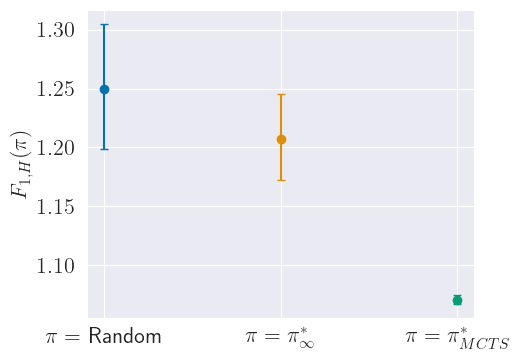

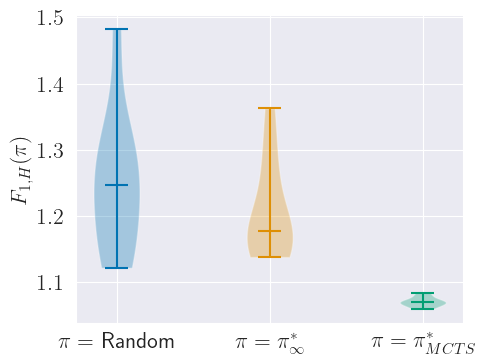

In [25]:
plot_2(data_to_plot, mdp_name=f"adversarial_mdp_exp_steps_{exp_steps[exp_idx_to_plot]}")
plot_3(data_to_plot, mdp_name=f"adversarial_mdp_exp_steps_{exp_steps[exp_idx_to_plot]}")

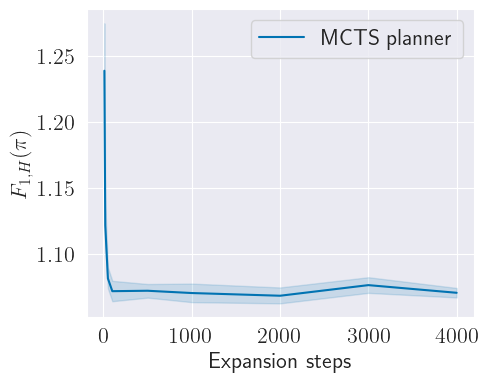

In [26]:
plt.figure(figsize=(5.0, 4.0))

ys_mcts_planner = []
mcts_planner_cis = []

for mcts_data_path in mcts_planner_data:
    y_vals = load_mcts_data(env, mcts_data_path)
    ys_mcts_planner.append(np.mean(y_vals))

    cis = mean_ci(y_vals)
    mcts_planner_cis.append(np.array(cis))

mcts_planner_cis = np.array(mcts_planner_cis)

p = plt.plot(exp_steps, ys_mcts_planner, label="MCTS planner")
plt.fill_between(exp_steps, mcts_planner_cis[:,0], mcts_planner_cis[:,1], color=p[0].get_color(), alpha=0.15)

plt.ylabel(r'$F_{1,H}(\pi)$')
plt.xlabel('Expansion steps')
plt.grid()
plt.legend()

# plt.ylim(-2.0, -1.5)

os.makedirs("figs/", exist_ok=True)
plt.savefig(f'figs/adversarial_mdp_plot_exp_steps.pdf', bbox_inches='tight', pad_inches=0)
plt.show()